<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/simple/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

# from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [177]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

mkdir: cannot create directory ‘data’: File exists
--2020-06-29 17:03:58--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2552121 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  3.09MB/s    in 0.8s    

2020-06-29 17:04:01 (3.09 MB/s) - ‘/content/data/raw.zip’ saved [2552121/2552121]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx 

In [178]:
def st_to_mt(st):
  return st/1.10231131

Load Price data

In [179]:
# por ahora solo SC y SR
ignore = ['SR', 'HU', 'HC', 'AM', 'UP']

In [180]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = {}

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name in ignore: continue
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames[name] = d

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames.values()]
price_df = pd.concat(dfs, axis=1)

price_df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15
Date,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0


In [181]:
all_df = price_df

In [182]:
# Contamos los valores nulos del dataset -> 0
all_df.isnull().sum().sum()

0

# Análisis

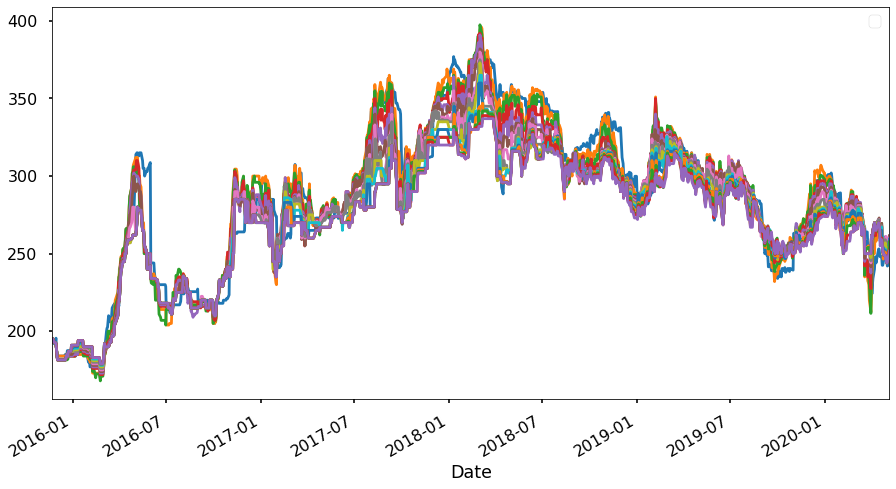

In [183]:
fig, ax = subplots()
price_df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

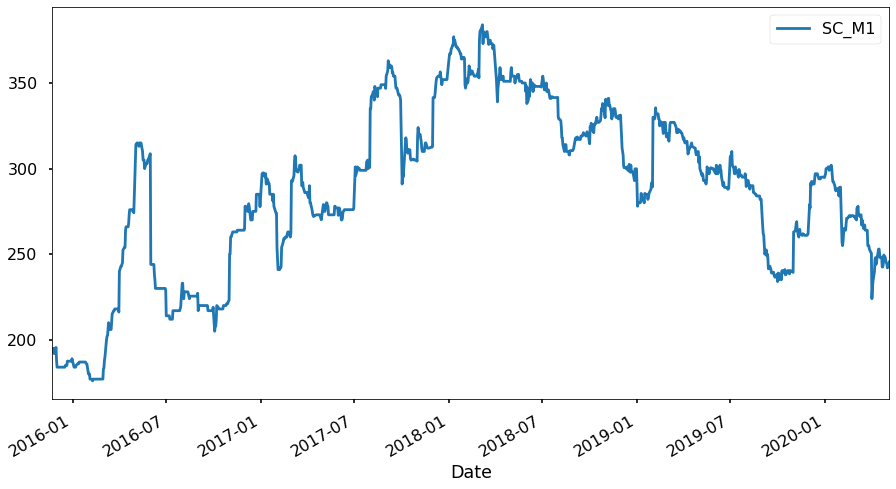

In [184]:
price_df[['SC_M1']].plot(figsize=(15,8))

In [185]:
data = all_df.reset_index().copy()

Hacemos una columna para poder hacer la predicción. Iteramos por las columnas SC y vamos añadiendo los valores a una única columna (SC_M1). Por ejemplo, el valor de SC_M12 se añade 12 meses más tarde.

In [186]:
from collections import defaultdict

def simplify_df(dff):
    dff = dff.copy()

    print(dff.columns)
    exclude = ['Date', 'TV', 'EOI']
    cols = [c for c in dff.columns if all([x not in c for x in exclude])]
    firsts = [c for c in cols if '1' in c and len(c) <= 5]
    others = [c for c in cols if c not in firsts]

    d = defaultdict(list)
    for o in others:
        k = [f for f in firsts if f[:2] == o[:2]][0]
        d[k].append(o)
    d = dict(d)

    new_df = dff.copy()
    count = 0
    for r in dff.itertuples():
        for k, vs in d.items():
            for v in vs:
                next_row = r.Date + pd.DateOffset(months=int(v[4:])-1)
                new_val = new_df.loc[new_df.Date == r.Date, v].values[0]

                if next_row not in pd.to_datetime(new_df.Date.values):
                    new_df = new_df.append({'Date': next_row}, ignore_index=True)

                vals = new_df.loc[new_df.Date == next_row, k]
                if new_df.loc[new_df.Date == next_row, k].isnull().any():
                    new_df.loc[new_df.Date == next_row, k] = new_val
                else:
                    l = [new_df.loc[new_df.Date == next_row, k], new_val]
                    new_df.loc[new_df.Date == next_row, k] = sum(l)/len(l)

    new_df.drop(others, axis=1, inplace=True)
    new_df.sort_values(by='Date', inplace=True)
    new_df = new_df.loc[new_df.Date < max_date]
    return new_df.drop_duplicates()

In [187]:
max_date = data.Date.max()
simp_df = simplify_df(data)
simp_df.head()

Index(['Date', 'SC_M1', 'SC_M2', 'SC_M3', 'SC_M4', 'SC_M5', 'SC_M6', 'SC_M7',
       'SC_M8', 'SC_M9', 'SC_M10', 'SC_M11', 'SC_M12', 'SC_M13', 'SC_M14',
       'SC_M15'],
      dtype='object')


,Date,SC_M1
0,2015-11-23,195.0
1,2015-11-24,195.0
2,2015-11-25,195.0
3,2015-11-26,192.0
4,2015-11-27,192.0


In [188]:
print(simp_df.shape)
simp_df.isnull().sum()

(1616, 2)


Date     0
SC_M1    0
dtype: int64

In [189]:
simp_df['mean'] = simp_df['SC_M1'].rolling(window=20).mean()

simp_df['std'] = simp_df['SC_M1'].rolling(window=20).std() 

simp_df['upper'] = simp_df['mean'] + (simp_df['std'] * 2)
simp_df['lower'] = simp_df['mean'] - (simp_df['std'] * 2)

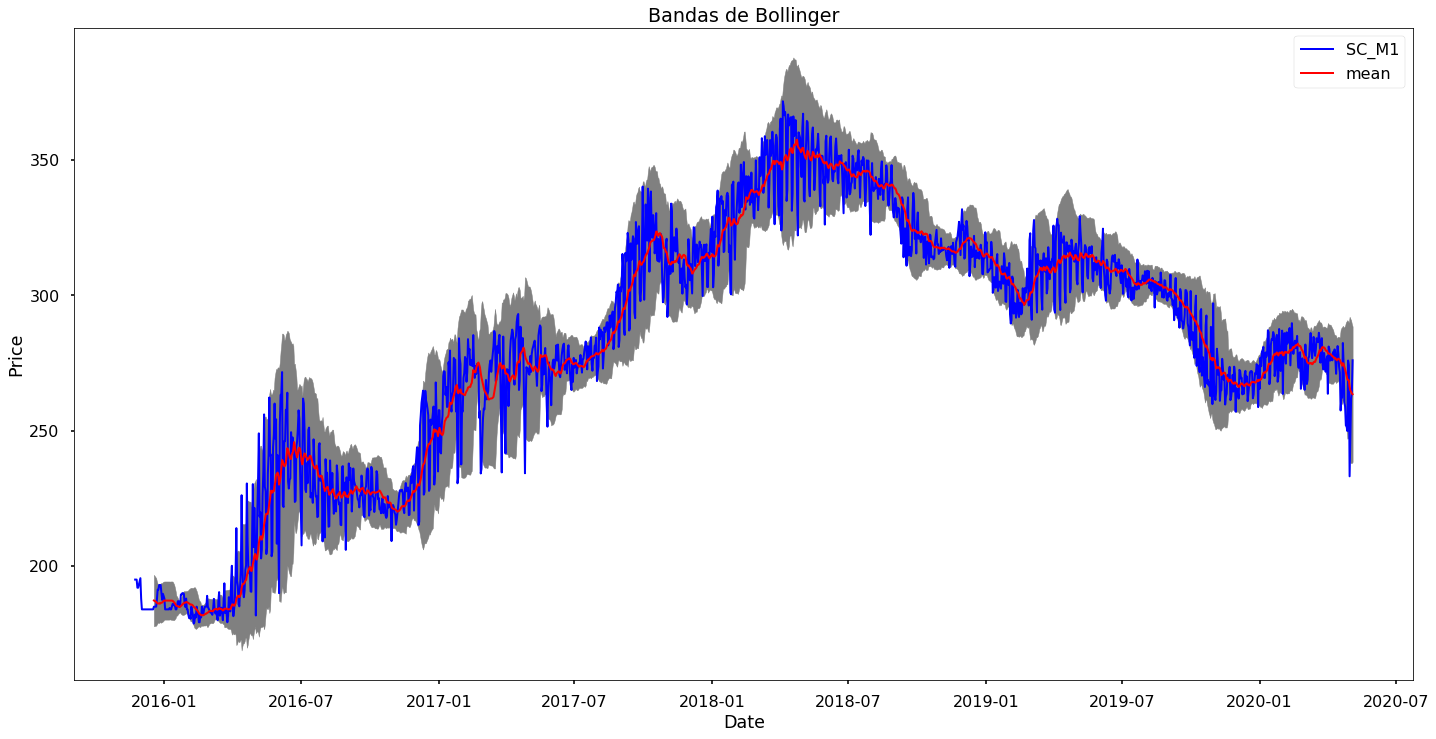

Desviación estándar media: 8.22935667542243
Max: 387.80643137091374
Min: 168.83559089251347


In [191]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot()
fig.patch.set_facecolor('w')

x_axis = simp_df['Date'].values

ax.fill_between(x_axis, simp_df['upper'], simp_df['lower'], color='grey')

ax.plot(x_axis, simp_df['SC_M1'], color='b', lw=2)
ax.plot(x_axis, simp_df['mean'], color='r', lw=2)

ax.set_title('Bandas de Bollinger')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['SC_M1', 'mean'])
plt.show()

print('Desviación estándar media:', simp_df['std'].mean())
print('Max:', simp_df['upper'].max())
print('Min:', simp_df['lower'].min())

En el gráfico queda representado el precio de la chatarra de los últimos 4 años. Se observan periodos más volátiles, (las bandas están más separadas), que se suelen corresponder con un cambio rápido de precio.

En ocasiones, el precio sale de las bandas. Si sale por arriba (como es el caso de marzo de 2016), indica que los precios han subido mucho, muy rápido (es decir, que se ha comprado mucho y ha disminuido la oferta, incrementando así el precio.

Cuando el precio sale por debajo de las bandas significa que se ha vendido mucho en un periodo de tiempo muy rápido, lo cual causa un descenso rápido del precio. Supongo que ésta sería una buena ocasión para comprar, ya que los precios son más bajos.

Sin embargo, los periodos donde las bandas están más separadas son los de más volatilidad e incertidumbre.

Se puede observar una tendencia. Tras periodos de alta volatilidad (debido a grandes cambios en el precio), vienen periodos donde las bandas están más juntas y los precios más estables. Esto puede ser útil a la hora de decidir si comprar o no, ya que se puede estimar el cambio de precio futuro en base a la estabilidad del precio actual.

# Model

Separamos el dataset en ```X``` e ```y```. Para hallar ```X```, usamos el número de días que han pasado desde el primer dato. ```y``` es el valor a predecir (SC_M1).

In [23]:
def get_features(dff):
    dff = dff.copy()

    others = [c for c in dff.columns if c not in ['Date', to_predict]]
    dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
    dff.set_index(dff.ds, inplace=True)

    dff = add_caps(dff)
    dff['day'] = (dff.index - dff.index[0]).days
    X = dff[['day']]
    y = dff[['y']]

    return X, y

Hacemos train/test split

In [24]:
to_predict = 'SC_M1'
X, y = get_features(simp_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Regresión Lineal

In [25]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
l_preds = linear_model.predict(X_test)

In [32]:
print ('W: ', linear_model.coef_) # pendiente
print ('B: ', linear_model.intercept_) # coordenada de intersección con el eje Y

W:  [[0.02080782]]
B:  [257.51696277]


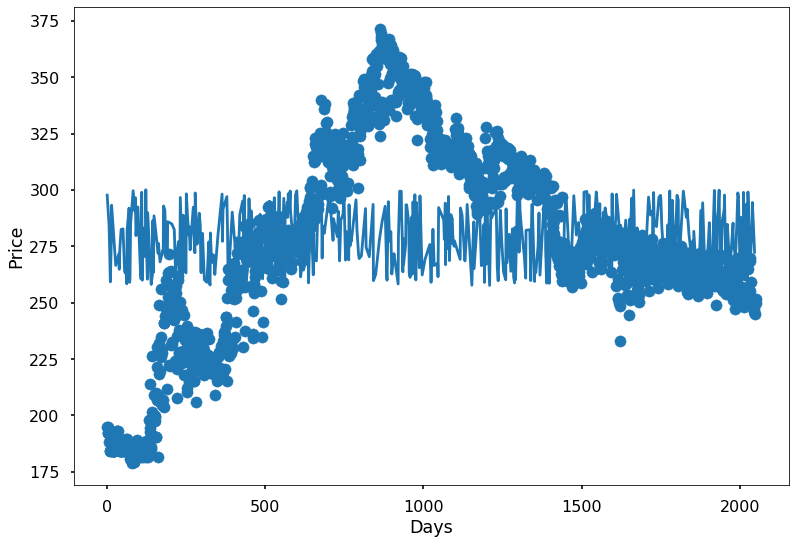

In [33]:
scatter(X_train, y_train)
plot(np.sort(X_test, axis=0), l_preds)
xlabel("Days")
ylabel("Price")
plt.show()

In [28]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(l_preds - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((l_preds - y_test) ** 2))
print('Accuracy: {:.2f}%'.format(r2_score(l_preds, y_test)*100))

Mean absolute error: 35.08
Residual sum of squares (MSE): 1700.39
Accuracy: -963.08%


La regresión lineal no tiene complejidad suficiente para ajustarse a los datos.

## Regresión Polinómica

Para hacer una regresión polinómica hacemos una regresión lineal, pero transformando antes los datos.

In [34]:
deg = 5 # grado del polinomio
poly = PolynomialFeatures(degree=deg)
X_train_poly = poly.fit_transform(X_train)

In [35]:
poly_model = LinearRegression()
train_y_ = poly_model.fit(X_train_poly, y_train)
print ('W: ', poly_model.coef_)
print ('B: ', poly_model.intercept_)

W:  [[ 0.00000000e+00 -1.27261896e-01  1.15114201e-03 -1.46650710e-06
   6.84222369e-10 -1.09384724e-13]]
B:  [197.32100802]


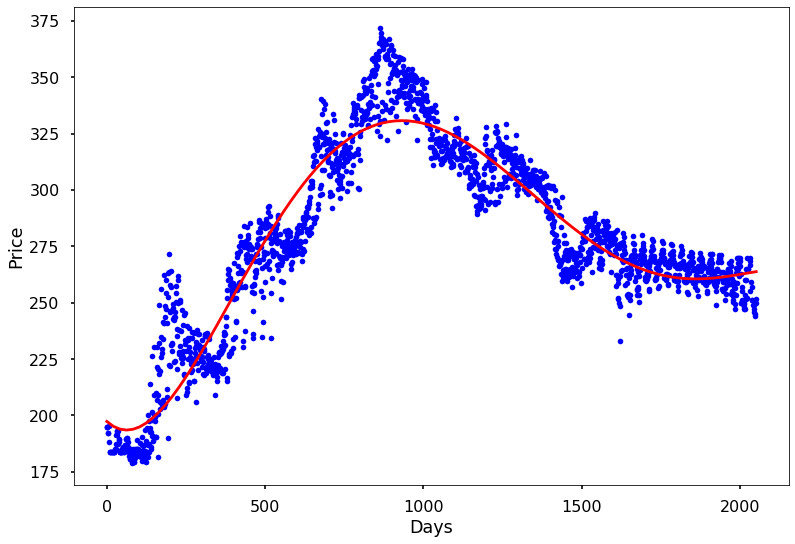

In [36]:
X_plot = np.linspace(min(X_train.day), max(X_train.day), 100).reshape(-1,1)
X_plot_poly = poly.fit_transform(X_plot)
plt.plot(X, y, "b.")
plot(X_plot_poly[:, 1], poly_model.predict(X_plot_poly), '-r')
xlabel("Days")
ylabel("Price")

plt.show()

In [31]:
test_x_poly = poly.fit_transform(X_test)
p_preds = poly_model.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(p_preds - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((p_preds - y_test) ** 2))
print('Accuracy: {:.2f}%'.format(r2_score(p_preds, y_test)*100))

Mean absolute error: 10.19
Residual sum of squares (MSE): 170.61
Accuracy: 89.73%


**Este modelo se ajusta mucho mejor a los datos.**

In [170]:
periods = 180 # Predecir 6 meses
rang = range(X.day[-1], X.day[-1] + periods)
idx = pd.date_range(max_date, periods=periods)

future_x = pd.DataFrame(rang, columns=['day'])
future_x.set_index(idx, inplace=True)
future_x.index.name = 'ds'
print(future_x.head())

future_y = pd.DataFrame(np.zeros(periods), columns=['y'])
future_y.set_index(idx, inplace=True)
print(future_y.head())

             day
ds              
2020-05-05  2051
2020-05-06  2052
2020-05-07  2053
2020-05-08  2054
2020-05-09  2055
              y
2020-05-05  0.0
2020-05-06  0.0
2020-05-07  0.0
2020-05-08  0.0
2020-05-09  0.0


In [171]:
fut_poly = poly.fit_transform(future_x)
future_preds = poly_model.predict(fut_poly)

X_f = X.append(future_x)
future_y.y = future_preds
y_f = y.append(future_y)

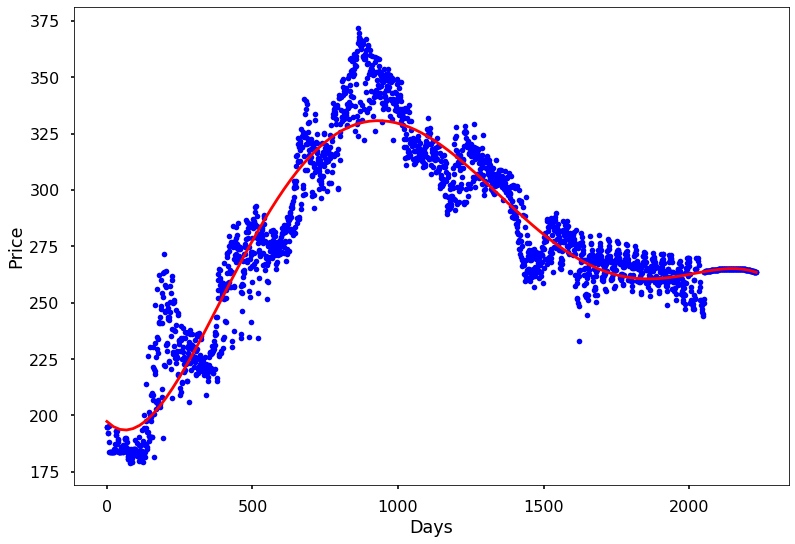

In [172]:
# Representación de los resultados

X_plot = np.linspace(min(X_f.day), max(X_f.day), 100).reshape(-1,1)
X_plot_poly = poly.fit_transform(X_plot)

plt.plot(X_f, y_f, "b.")
plot(X_plot_poly[:, 1], poly_model.predict(X_plot_poly), '-r')
xlabel("Days")
ylabel("Price")
plt.show()

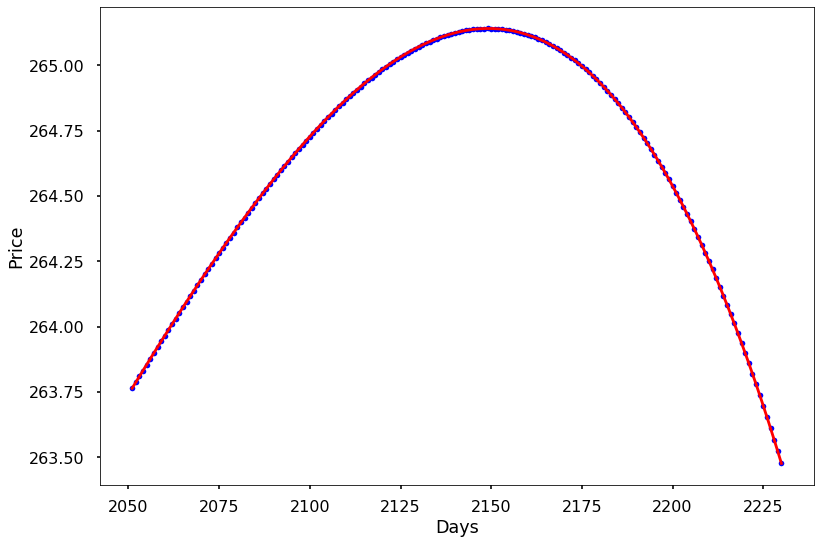

In [173]:
# Con más detalle

X_plot = np.linspace(min(future_x.day), max(future_x.day), 100).reshape(-1,1)
X_plot_poly = poly.fit_transform(X_plot)

plt.plot(future_x, future_y, "b.")
plot(X_plot_poly[:, 1], poly_model.predict(X_plot_poly), '-r')
xlabel("Days")
ylabel("Price")
plt.show()